Setup Environment

In [5]:
!pip install transformers datasets accelerate evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


Import Library

In [6]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [7]:
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Memory: 15.83 GB


Load Dataset

In [8]:
# Load IMDB dataset dari HuggingFace Hub
dataset_1 = load_dataset("ag_news")
dataset_2 = load_dataset("go_emotions")
dataset_3 = load_dataset("glue", "mnli")

print("Dataset structure:")
print(dataset_1)
print(dataset_2)
print(dataset_3)
print("\n" + "="*50)

print("dataset 1, ag_news: ")
print(f"Training samples: {len(dataset_1['train'])}")
print(f"Test samples: {len(dataset_1['test'])}")

print("dataset 2, go_emotions: ")
print(f"Training samples: {len(dataset_2['train'])}")
print(f"Test samples: {len(dataset_2['test'])}")

print("dataset 3, mnli: ")
print(f"Training samples: {len(dataset_3['train'])}")
print(f"Test samples (matched): {len(dataset_3['test_matched'])}")
print(f"Test samples (mismatched): {len(dataset_3['test_mismatched'])}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        nu

## Visualize AG News Class Distribution

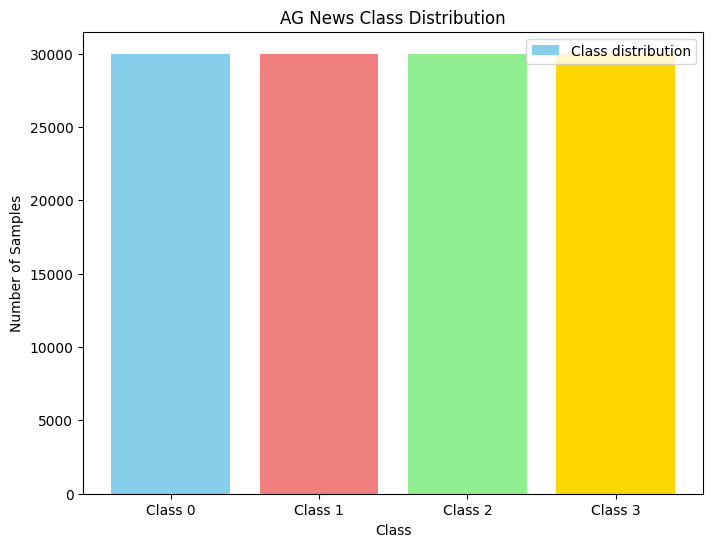

In [9]:
import matplotlib.pyplot as plt

# Extract labels from the training split of dataset_1
labels = dataset_1['train']['label']

# Count the occurrences of each label
class_distribution = {}
for label in labels:
    class_distribution[label] = class_distribution.get(label, 0) + 1

# Sort the classes for consistent plotting
sorted_classes = sorted(class_distribution.items())
class_names = [f"Class {cls[0]}" for cls in sorted_classes]
class_counts = [cls[1] for cls in sorted_classes]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

# Add title and labels
plt.title('AG News Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# Add legend (optional, as classes are on x-axis, but good for clarity)
plt.legend(['Class distribution'], loc='upper right')

# Display the plot
plt.show()


## Visualisasi Go Emotions Class Distribution

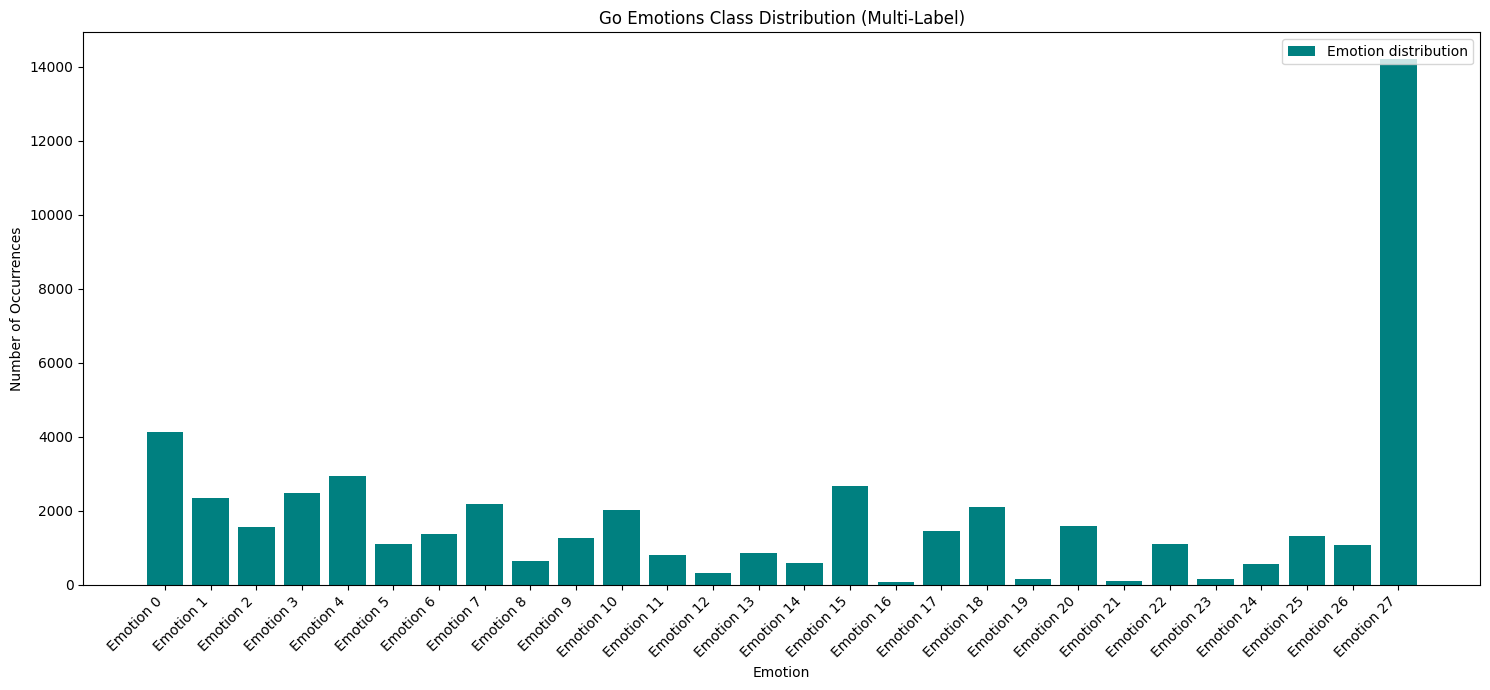

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

# Extract labels from the training split of dataset_2
# Each entry is a list of emotion labels
all_labels = dataset_2['train']['labels']

# Count the occurrences of each individual label
# Since it's multi-label, we flatten the list of lists first
flat_labels = [label for sublist in all_labels for label in sublist]
class_distribution_go_emotions = Counter(flat_labels)

# Sort the classes for consistent plotting
sorted_classes_go_emotions = sorted(class_distribution_go_emotions.items())
class_names_go_emotions = [f"Emotion {cls[0]}" for cls in sorted_classes_go_emotions]
class_counts_go_emotions = [cls[1] for cls in sorted_classes_go_emotions]

# Create a bar chart
plt.figure(figsize=(15, 7)) # Adjust figure size for more labels
plt.bar(class_names_go_emotions, class_counts_go_emotions, color='teal')

# Add title and labels
plt.title('Go Emotions Class Distribution (Multi-Label)')
plt.xlabel('Emotion')
plt.ylabel('Number of Occurrences')

# Rotate x-axis labels if there are many to prevent overlap
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(['Emotion distribution'], loc='upper right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()

### Visualisasi MNLI Class Distribution

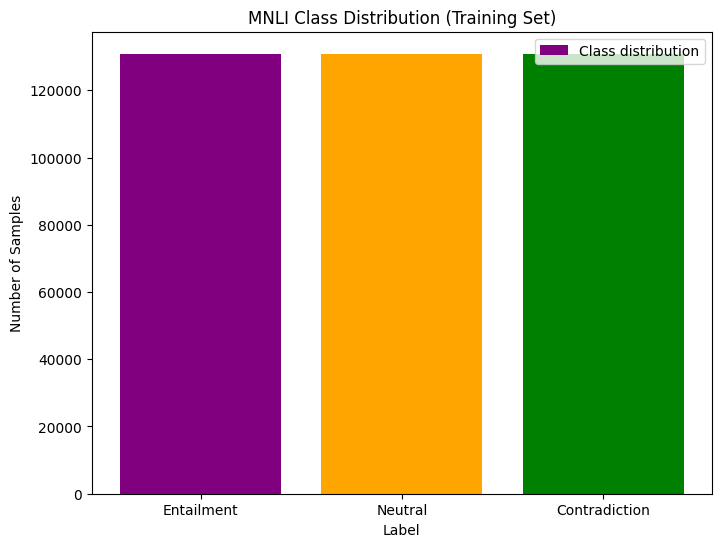

In [11]:
import matplotlib.pyplot as plt

# Extract labels from the training split of dataset_3
labels_mnli = dataset_3['train']['label']

# Count the occurrences of each label
class_distribution_mnli = {}
for label in labels_mnli:
    class_distribution_mnli[label] = class_distribution_mnli.get(label, 0) + 1

# Map numerical labels to meaningful names for MNLI (0: entailment, 1: neutral, 2: contradiction)
mnli_label_map = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}

# Sort the classes for consistent plotting
sorted_classes_mnli = sorted(class_distribution_mnli.items())
class_names_mnli = [mnli_label_map[cls[0]] for cls in sorted_classes_mnli]
class_counts_mnli = [cls[1] for cls in sorted_classes_mnli]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_names_mnli, class_counts_mnli, color=['purple', 'orange', 'green'])

# Add title and labels
plt.title('MNLI Class Distribution (Training Set)')
plt.xlabel('Label')
plt.ylabel('Number of Samples')

# Add legend
plt.legend(['Class distribution'], loc='upper right')

# Display the plot
plt.show()

## Load Tokenizer and Define Preprocessing Functions (ag_news)


Langkah pertama adalah memuat tokenizer pra-latih sesuai instruksi, kemudian mendefinisikan fungsi tokenisasi generik yang bisa diadaptasi untuk berbagai dataset, baik untuk input satu kalimat maupun pasangan kalimat. Pendekatan ini menyiapkan logika tokenisasi inti untuk fungsi praproses berikutnya

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples, text_key='text', text_pair_key=None, max_length=128):
    if text_pair_key:
        return tokenizer(examples[text_key], examples[text_pair_key], truncation=True, padding='max_length', max_length=max_length)
    else:
        return tokenizer(examples[text_key], truncation=True, padding='max_length', max_length=max_length)

print("Tokenizer loaded and generic tokenize_function defined.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded and generic tokenize_function defined.


Sekarang setelah tokenizer dan fungsi tokenisasi generik sudah didefinisikan, langkah berikutnya adalah membuat fungsi praproses spesifik untuk masing-masing dari tiga dataset (ag_news, go_emotions, dan mnli), dengan menyesuaikannya terhadap format input dan tipe label yang khas pada tiap dataset. Ini mencakup penanganan input satu kalimat, pasangan kalimat, serta konversi label multi-kelas menjadi representasi multi-hot encoding untuk tugas multi-label.


In [13]:
import torch

# Preprocessing function for AG News (single-label classification)
def preprocess_ag_news(examples):
    tokenized_inputs = tokenize_function(examples, text_key='text')
    tokenized_inputs["labels"] = examples["label"]
    return tokenized_inputs

# Preprocessing function for Go Emotions (multi-label classification)
def preprocess_go_emotions(examples):
    tokenized_inputs = tokenize_function(examples, text_key='text')

    # Determine the number of unique labels for multi-hot encoding
    # Using the flat_labels from the earlier visualization step
    num_labels_go_emotions = len(set(flat_labels))

    # Convert list of labels to multi-hot encoded tensor
    multi_hot_labels = []
    for label_list in examples["labels"]:
        # Create a zero vector of size num_labels_go_emotions
        one_hot_vector = [0] * num_labels_go_emotions
        for label_idx in label_list:
            one_hot_vector[label_idx] = 1
        multi_hot_labels.append(one_hot_vector)

    tokenized_inputs["labels"] = multi_hot_labels
    return tokenized_inputs

# Preprocessing function for MNLI (sentence-pair classification)
def preprocess_mnli(examples):
    tokenized_inputs = tokenize_function(examples, text_key='premise', text_pair_key='hypothesis')
    tokenized_inputs["labels"] = examples["label"]
    return tokenized_inputs

print("Preprocessing functions for AG News, Go Emotions, and MNLI defined.")

Preprocessing functions for AG News, Go Emotions, and MNLI defined.


## Preprocess and Fine-tune for AG News

Pertama, dataset ag_news perlu dipraproses menggunakan fungsi preprocess_ag_news yang sudah didefinisikan sebelumnya. Langkah ini mencakup tokenisasi teks, penanganan label, menghapus kolom yang tidak digunakan, serta mengatur format ke 'torch' agar kompatibel dengan model.
​

In [14]:
tokenized_ag_news_dataset = dataset_1.map(preprocess_ag_news, batched=True)

# Remove unused columns and set format to PyTorch tensors
tokenized_ag_news_dataset = tokenized_ag_news_dataset.remove_columns(["text"])
tokenized_ag_news_dataset.set_format("torch")

# Shuffle the training set
tokenized_ag_news_dataset["train"] = tokenized_ag_news_dataset["train"].shuffle(seed=42)

print("AG News dataset preprocessed and formatted for PyTorch.")
print(tokenized_ag_news_dataset)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

AG News dataset preprocessed and formatted for PyTorch.
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7600
    })
})


In [15]:
num_labels_ag_news = dataset_1['train'].features['label'].num_classes
print(f"Number of labels for AG News dataset: {num_labels_ag_news}")

Number of labels for AG News dataset: 4


Setelah jumlah label ditentukan, langkah berikutnya adalah memuat AutoModelForSequenceClassification dengan checkpoint bert-base-uncased dan menspesifikasikan num_labels sesuai nilai tersebut. Selanjutnya, model dipindahkan ke perangkat yang sesuai (GPU jika tersedia, jika tidak maka CPU) agar siap digunakan dalam proses pelatihan.
​

In [16]:
model_ag_news = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels_ag_news
).to(device)

print(f"AG News classification model loaded to {device}.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AG News classification model loaded to cuda.


Deklarasikan compute metrics untuk perhitungan nilai error.


In [17]:
def compute_metrics(eval_pred):
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted') # Use 'weighted' for multi-class classification

    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

print("compute_metrics function defined.")

compute_metrics function defined.


Sekarang setelah fungsi compute_metrics didefinisikan, langkah selanjutnya adalah mengonfigurasi TrainingArguments untuk menetapkan parameter pelatihan model AG News, seperti direktori output, strategi evaluasi, laju pembelajaran, ukuran batch, jumlah epoch, dan weight decay. Selain itu, pengaturan penyimpanan model terbaik juga perlu diaktifkan (misalnya dengan load_best_model_at_end=True dan metric_for_best_model yang sesuai) agar model dengan performa terbaik selama pelatihan otomatis disimpan sesuai instruksi.
​

In [18]:
training_args_ag_news = TrainingArguments(
    output_dir="./results_ag_news",          # Output directory
    eval_strategy="epoch",             # Evaluation is done at the end of each epoch
    learning_rate=2e-5,                  # Learning rate
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=16,       # Batch size for evaluation
    num_train_epochs=3,                  # Total number of training epochs
    weight_decay=0.01,                   # Strength of weight decay
    logging_dir='./logs_ag_news',        # Directory for storing logs
    logging_steps=500,                   # Log every X updates steps
    save_strategy="epoch",               # Save checkpoint every epoch
    load_best_model_at_end=True,         # Load the best model at the end of training
    metric_for_best_model='f1',          # Use F1 score to determine the best model
    report_to="none"                     # Disable reporting to experiment tracking platforms
)

print("TrainingArguments for AG News configured.")

TrainingArguments for AG News configured.


In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer_ag_news = Trainer(
    model=model_ag_news,
    args=training_args_ag_news,
    train_dataset=tokenized_ag_news_dataset["train"],
    eval_dataset=tokenized_ag_news_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer for AG News initialized.")

Trainer for AG News initialized.


Mulai training

In [ ]:
print("Starting AG News model training...")
trainer_ag_news.train()
print("AG News model training complete.")

Starting AG News model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.192600,0.179012,0.940526,0.940577
2,0.130700,0.185407,0.949474,0.949429
3,0.088300,0.225273,0.947895,0.947923


AG News model training complete.


Checkpoint

In [22]:
from transformers import AutoModelForSequenceClassification
from google.colab import drive

drive.mount('/content/drive')
checkpoint_path = "/content/drive/MyDrive/finalterm-deeplearning/results_ag_news/checkpoint-45000/"

model_ag_news = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_path,
    num_labels=4
)


trainer_ag_news.train(resume_from_checkpoint=checkpoint_path)
trainer_ag_news.evaluate()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


	per_device_train_batch_size: 16 (from args) != 8 (from trainer_state.json)
Could not locate the best model at ./results_ag_news\checkpoint-30000/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.2671200931072235,
 'eval_accuracy': 0.9476315789473684,
 'eval_f1': 0.9476413933378107,
 'eval_runtime': 52.2557,
 'eval_samples_per_second': 145.439,
 'eval_steps_per_second': 9.09,
 'epoch': 3.0}

Inferensi text

In [24]:
import torch

# pastiin model mode eval
model_ag_news.eval()

# contoh teks (bebas lo ganti)
texts = [
    "Apple releases a new iPhone with improved camera and battery life",
    "The stock market crashed after the central bank raised interest rates",
    "The local team won the championship after a dramatic final match",
    "The president met with foreign leaders to discuss climate change"
]

# tokenize
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# pindahin ke device yang sama (GPU / CPU)
device = trainer_ag_news.args.device
inputs = {k: v.to(device) for k, v in inputs.items()}
model_ag_news.to(device)

# inferensi
with torch.no_grad():
    outputs = model_ag_news(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# mapping label AG News
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# print hasil
for text, pred in zip(texts, predictions):
    print(f"Teks: {text}")
    print(f"Prediksi: {label_map[pred.item()]}")
    print("-" * 50)


Teks: Apple releases a new iPhone with improved camera and battery life
Prediksi: Sci/Tech
--------------------------------------------------
Teks: The stock market crashed after the central bank raised interest rates
Prediksi: Business
--------------------------------------------------
Teks: The local team won the championship after a dramatic final match
Prediksi: Sports
--------------------------------------------------
Teks: The president met with foreign leaders to discuss climate change
Prediksi: World
--------------------------------------------------


## Preprocess and fine tune for Go Emotions

Pada tahap ini, fungsi preprocess_go_emotions diterapkan pada dataset_2 untuk menyiapkan data Go Emotions bagi tugas klasifikasi multi-label. Proses ini mencakup tokenisasi teks, pembuatan label dalam bentuk multi-hot encoding, penghapusan kolom yang tidak digunakan, serta pengaturan format keluaran menjadi tensor PyTorch agar kompatibel dengan model.


In [2]:
import torch

# Preprocessing function for Go Emotions (multi-label classification)
def preprocess_go_emotions(examples):
    tokenized_inputs = tokenize_function(examples, text_key='text')

    # Determine the number of unique labels for multi-hot encoding
    # Using the flat_labels from the earlier visualization step
    # Ensure num_labels_go_emotions is accessible, or recompute it if needed
    # For robustness, we can recompute it here or assume it's globally available
    global flat_labels # Assuming flat_labels is globally available from previous cell
    num_labels_go_emotions = len(set(flat_labels)) # Recompute for safety if not guaranteed global

    # Convert list of labels to multi-hot encoded tensor
    multi_hot_labels = []
    for label_list in examples["labels"]:
        # Create a zero vector of size num_labels_go_emotions
        one_hot_vector = [0.0] * num_labels_go_emotions # Initialize with floats
        for label_idx in label_list:
            one_hot_vector[label_idx] = 1.0 # Assign float values
        multi_hot_labels.append(one_hot_vector)

    # Ensure labels are explicitly converted to torch.float32 for BCEWithLogitsLoss
    tokenized_inputs["labels"] = torch.tensor(multi_hot_labels, dtype=torch.float32)
    return tokenized_inputs

# Preprocessing function for MNLI (sentence-pair classification)
def preprocess_mnli(examples):
    tokenized_inputs = tokenize_function(examples, text_key='premise', text_pair_key='hypothesis')
    tokenized_inputs["labels"] = examples["label"]
    return tokenized_inputs

print("Preprocessing functions for Go Emotions, and MNLI defined.")

Preprocessing functions for Go Emotions, and MNLI defined.


In [26]:
tokenized_go_emotions_dataset = dataset_2.map(preprocess_go_emotions, batched=True, remove_columns=dataset_2['train'].column_names)

# Set format to PyTorch tensors
tokenized_go_emotions_dataset.set_format("torch")

print("Go Emotions dataset preprocessed and formatted for PyTorch.")
print(tokenized_go_emotions_dataset)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Go Emotions dataset preprocessed and formatted for PyTorch.
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})


Langkah selanjutnya ini menerapkan fungsi preprocess_go_emotions pada dataset_2 secara batched untuk menyiapkan data Go Emotions bagi tugas klasifikasi multi-label, termasuk tokenisasi teks, pembuatan label dalam bentuk multi-hot, dan penghapusan kolom yang tidak digunakan. Setelah itu, format dataset diatur menjadi tensor PyTorch sehingga keluaran dapat langsung dikonsumsi oleh model selama proses pelatihan dan evaluasi, yang kemudian dikonfirmasi dengan mencetak pesan dan ringkasan struktur dataset yang sudah dipraproses.


Lalu, menentukan jumlah label dan model

In [29]:
go_emotions_labels = tokenized_go_emotions_dataset["train"].features["labels"].feature.names


In [30]:
from transformers import AutoModelForSequenceClassification

model_go_emotions = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",  # atau base model yang lo pake waktu training awal
    num_labels=len(go_emotions_labels),
    problem_type="multi_label_classification"
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Deklarasi args untuk training

In [43]:
training_args_go_emotions = TrainingArguments(
    output_dir="./results_go_emotions",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_go_emotions",
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    report_to="none",
    fp16=True   # ⬅️ INI KUNCI
)


Deklaarasi perhitungan metrics

In [37]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metrics_go_emotions(eval_pred):
    logits, labels = eval_pred
    # sigmoid karena multi-label
    probs = 1 / (1 + np.exp(-logits))

    # threshold (standar 0.5)
    y_pred = (probs >= 0.5).astype(int)

    return {
        "f1_micro": f1_score(labels, y_pred, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, y_pred, average="macro", zero_division=0),
    }


Deklarasi trainer dengan custom data collator

Kelas CustomDataCollatorWithPadding dibuat dengan mewarisi DataCollatorWithPadding untuk memastikan bahwa setelah proses padding dan batching, kolom labels dikonversi secara eksplisit ke tipe float32, yang dibutuhkan untuk klasifikasi multi-label dengan loss berbasis probabilitas (misalnya BCEWithLogitsLoss). Data collator kustom ini kemudian diberikan ke Trainer sebagai data_collator, sehingga setiap batch untuk model Go Emotions akan diproses dengan padding dinamis dan tipe label yang benar, sehingga mencegah error tipe tensor dan menjamin pelatihan berjalan sesuai spesifikasi tugas multi-label.
​

In [44]:
import torch
from transformers import DataCollatorWithPadding

class CustomDataCollatorWithPadding(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        # Ensure labels are explicitly converted to float32 after batching/padding
        if "labels" in batch and batch["labels"].dtype != torch.float32:
            batch["labels"] = batch["labels"].to(torch.float32)
        return batch

data_collator_go_emotions = CustomDataCollatorWithPadding(tokenizer=tokenizer)

trainer_go_emotions = Trainer(
    model=model_go_emotions,
    args=training_args_go_emotions,
    train_dataset=tokenized_go_emotions_dataset["train"],
    eval_dataset=tokenized_go_emotions_dataset["validation"],
    data_collator=data_collator_go_emotions, # Use the custom data collator
    compute_metrics=compute_metrics_go_emotions,
)

print("Trainer for Go Emotions re-initialized with custom data collator.")

Trainer for Go Emotions re-initialized with custom data collator.


Mulai training


In [ ]:
print("Starting Go Emotions model training...")
trainer_go_emotions.train()
print("Go Emotions model training complete.")

Starting Go Emotions model training...


Epoch,Training Loss,Validation Loss,Micro F1,Exact Match Accuracy
1,0.098700,0.092660,0.520746,0.383155
2,0.082600,0.085564,0.566794,0.443605
3,0.070700,0.085796,0.575504,0.459086


Go Emotions model training complete.


Checkpoint

In [45]:
from transformers import AutoModelForSequenceClassification

checkpoint_path_go = "/content/drive/MyDrive/finalterm-deeplearning/results_go_emotions/checkpoint-8142"


model_go_emotions = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_path_go,
    problem_type="multi_label_classification",
    num_labels=len(go_emotions_labels)
)

trainer_go_emotions.train(resume_from_checkpoint=checkpoint_path_go)
trainer_go_emotions.evaluate()


Could not locate the best model at ./results_go_emotions\checkpoint-2714/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.09244154393672943,
 'eval_f1_micro': 0.5751118126808734,
 'eval_f1_macro': 0.46489161753204494,
 'eval_runtime': 10.1254,
 'eval_samples_per_second': 535.882,
 'eval_steps_per_second': 33.579,
 'epoch': 3.0}

Inferensi

In [47]:
import torch

model_go_emotions.eval()

texts = [
    "I am so happy and grateful for your help!",
    "This is frustrating and makes me angry.",
    "I'm scared and nervous about the exam tomorrow.",
]

inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# HAPUS token_type_ids (DistilBERT gak pake)
if "token_type_ids" in inputs:
    inputs.pop("token_type_ids")

device = trainer_go_emotions.args.device
inputs = {k: v.to(device) for k, v in inputs.items()}
model_go_emotions.to(device)

with torch.no_grad():
    logits = model_go_emotions(**inputs).logits

probs = torch.sigmoid(logits).cpu().numpy()

THRESHOLD = 0.5

for text, prob in zip(texts, probs):
    emotions = [
        (go_emotions_labels[i], float(prob[i]))
        for i in range(len(prob)) if prob[i] >= THRESHOLD
    ]

    emotions = sorted(emotions, key=lambda x: x[1], reverse=True)

    print(f"Teks: {text}")
    if emotions:
        for e, s in emotions:
            print(f"  - {e}: {s:.3f}")
    else:
        print("  - Tidak ada emosi di atas threshold")
    print("-" * 50)


Teks: I am so happy and grateful for your help!
  - gratitude: 0.823
  - joy: 0.762
--------------------------------------------------
Teks: This is frustrating and makes me angry.
  - anger: 0.913
--------------------------------------------------
Teks: I'm scared and nervous about the exam tomorrow.
  - fear: 0.900
--------------------------------------------------


## Preprocess and Fine-tune for MNLI


Pertama, fungsi preprocess_mnli akan diterapkan pada dataset_3 (dataset MNLI) menggunakan metode .map() untuk melakukan tokenisasi pasangan kalimat (premise–hypothesis) dan menyiapkan label dalam format yang sesuai untuk tugas klasifikasi entailment. Proses ini juga mencakup penghapusan kolom teks dan indeks asli yang tidak lagi dibutuhkan, serta pengaturan format dataset menjadi tensor PyTorch sehingga dapat langsung digunakan oleh model selama pelatihan dan evaluasi.


In [48]:
tokenized_mnli_dataset = dataset_3.map(preprocess_mnli, batched=True, remove_columns=['premise', 'hypothesis', 'idx'])

# Set format to PyTorch tensors
tokenized_mnli_dataset.set_format("torch")

print("MNLI dataset preprocessed and formatted for PyTorch.")
print(tokenized_mnli_dataset)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

MNLI dataset preprocessed and formatted for PyTorch.
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9847
    })
})


Cek ada berapa jumlah label dalam data

In [49]:
num_labels_mnli = dataset_3['train'].features['label'].num_classes
print(f"Number of labels for MNLI dataset: {num_labels_mnli}")

Number of labels for MNLI dataset: 3


Sekarang setelah jumlah label untuk MNLI sudah ditentukan, langkah selanjutnya adalah memuat AutoModelForSequenceClassification menggunakan checkpoint bert-base-uncased, lalu mengonfigurasinya sebagai klasifikasi single-label dengan num_labels yang sesuai. Setelah itu, model dipindahkan ke device (GPU jika tersedia, jika tidak maka CPU) agar siap digunakan dalam proses pelatihan sesuai instruksi.


In [50]:
model_mnli = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels_mnli,
    problem_type="single_label_classification" # Explicitly set for sentence-pair classification
).to(device)

print(f"MNLI classification model loaded to {device}.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MNLI classification model loaded to cuda:0.


Setelah model untuk MNLI berhasil dimuat, langkah berikutnya adalah mengonfigurasi TrainingArguments khusus untuk tugas ini, dengan menetapkan direktori output dan log, strategi evaluasi, laju pembelajaran, ukuran batch, jumlah epoch, weight decay, serta kriteria penyimpanan model terbaik (misalnya load_best_model_at_end=True dan metric_for_best_model yang sesuai). Fungsi compute_metrics yang telah didefinisikan sebelumnya dapat digunakan kembali untuk MNLI karena sudah dirancang untuk menghitung metrik klasifikasi multi-kelas (seperti akurasi dan F1) berdasarkan argmax pada logits.
​



In [54]:
training_args_mnli = TrainingArguments(
    output_dir="./results_mnli",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs_mnli',
    logging_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to="none",
    fp16=True
)

print("TrainingArguments for MNLI configured.")

TrainingArguments for MNLI configured.


Setelah TrainingArguments untuk MNLI didefinisikan, langkah berikutnya adalah menginisialisasi objek Trainer khusus untuk tugas ini dengan memberikan model, argumen pelatihan, dataset latih dan validasi yang sudah ditokenisasi, data collator, serta fungsi compute_metrics yang telah disiapkan sebelumnya. Dengan konfigurasi ini, Trainer akan menangani seluruh proses pelatihan dan evaluasi MNLI secara terintegrasi, termasuk batching, padding, perhitungan metrik multi-kelas, dan penyimpanan model terbaik sesuai pengaturan yang telah ditentukan.
​



In [55]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer_mnli = Trainer(
    model=model_mnli,
    args=training_args_mnli,
    train_dataset=tokenized_mnli_dataset["train"],
    eval_dataset=tokenized_mnli_dataset["validation_matched"], # Using validation_matched for evaluation during training
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer for MNLI initialized.")

Trainer for MNLI initialized.


Mulai proses training

In [56]:
print("Starting MNLI model training...")
trainer_mnli.train()
print("MNLI model training complete.")

Starting MNLI model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.448700,0.430044,0.833928,0.834354
2,0.325900,0.432163,0.842995,0.843537
3,0.221700,0.486620,0.845644,0.846268


MNLI model training complete.


In [57]:
import torch

model_mnli.eval()

# contoh pasangan kalimat
pairs = [
    (
        "A soccer game with multiple males playing.",
        "Some men are playing a sport."
    ),
    (
        "A man is playing a guitar on stage.",
        "The man is sleeping."
    ),
    (
        "A woman is cooking in the kitchen.",
        "Someone is preparing food."
    )
]

premises = [p[0] for p in pairs]
hypotheses = [p[1] for p in pairs]

# tokenize pasangan kalimat
inputs = tokenizer(
    premises,
    hypotheses,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

device = trainer_mnli.args.device
inputs = {k: v.to(device) for k, v in inputs.items()}
model_mnli.to(device)

with torch.no_grad():
    logits = model_mnli(**inputs).logits

predictions = torch.argmax(logits, dim=-1).cpu().numpy()

# label MNLI
label_map = {
    0: "Contradiction",
    1: "Neutral",
    2: "Entailment"
}

# print hasil
for i, (premise, hypothesis) in enumerate(pairs):
    print(f"Premise    : {premise}")
    print(f"Hypothesis : {hypothesis}")
    print(f"Prediksi   : {label_map[predictions[i]]}")
    print("-" * 60)


Premise    : A soccer game with multiple males playing.
Hypothesis : Some men are playing a sport.
Prediksi   : Contradiction
------------------------------------------------------------
Premise    : A man is playing a guitar on stage.
Hypothesis : The man is sleeping.
Prediksi   : Entailment
------------------------------------------------------------
Premise    : A woman is cooking in the kitchen.
Hypothesis : Someone is preparing food.
Prediksi   : Contradiction
------------------------------------------------------------


Koreksi konfigurasi labeling. sehingga harus menimpa config model

In [63]:
model_mnli.config.id2label = {
    0: "entailment",
    1: "neutral",
    2: "contradiction"
}

model_mnli.config.label2id = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}


In [65]:
examples = [
    ("I am so hungry.", "I Just Ate."),
    ("A man is playing a guitar on stage.", "The man is sleeping."),
    ("A woman is cooking in the kitchen.", "Someone is preparing food."),
]

model_mnli.eval()
for premise, hypothesis in examples:
    inputs = tokenizer(
        premise,
        hypothesis,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to(device)

    with torch.no_grad():
        logits = model_mnli(**inputs).logits

    pred_id = torch.argmax(logits, dim=1).item()
    print("Premise   :", premise)
    print("Hypothesis:", hypothesis)
    print("Prediksi  :", model_mnli.config.id2label[pred_id])
    print("-"*50)


Premise   : I am so hungry.
Hypothesis: I Just Ate.
Prediksi  : neutral
--------------------------------------------------
Premise   : A man is playing a guitar on stage.
Hypothesis: The man is sleeping.
Prediksi  : contradiction
--------------------------------------------------
Premise   : A woman is cooking in the kitchen.
Hypothesis: Someone is preparing food.
Prediksi  : entailment
--------------------------------------------------
